In [1]:
import pandas as pd
import requests
import numpy as np
from datetime import datetime, timedelta
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import warnings; warnings.filterwarnings("ignore")
import json

In [2]:
train_the_model_switch = 'off' # off or on to train the model on code execution
stock_symbol = 'SBER'
interval = 24
periods_to_predict = 30
train_window = 30

In [3]:
# Function for obtaining data for a specified time interval with repeated attempts
def fetch_data(stock_symbol, start_date, end_date, interval=24, retries=3, delay=5):
    url = f"https://iss.moex.com/iss/engines/stock/markets/shares/securities/{stock_symbol}/candles.json"
    params = {
        'from': start_date,
        'till': end_date,
        'interval': interval
    }
    attempt = 0
    while attempt < retries:
        try:
            response = requests.get(url, params=params)
            if response.status_code == 200:
                return response.json()
            else:
                print(f"Error {response.status_code}: Unable to fetch data from {start_date} to {end_date}.")
                return None
        except requests.exceptions.RequestException as e:
            attempt += 1
            print(f"Attempt {attempt}/{retries} failed: {e}. Retrying in {delay} seconds...")
            time.sleep(delay)
    return None

# Function to generate sequential time intervals
def generate_date_ranges(start_date, end_date, delta=timedelta(days=365)):
    current_date = start_date
    while current_date < end_date:
        next_date = min(current_date + delta, end_date)
        yield current_date, next_date - timedelta(days=1)
        current_date = next_date

# The main function for pumping out data for the entire period
def download_full_history(stock_symbol, start_date, end_date, output_file):
    all_data = []
    
    # Generating intervals of one year
    for start, end in generate_date_ranges(start_date, end_date):
        start_str = start.strftime('%Y-%m-%d')
        end_str = end.strftime('%Y-%m-%d')
        print(f"Fetching data from {start_str} to {end_str}...")
        
        data = fetch_data(stock_symbol, start_str, end_str)
        if data and 'candles' in data:
            all_data.extend(data['candles']['data'])  # Adding data to the general list
        else:
            print(f"No data for period from {start_str} to {end_str}.")
    
    # Saving all data into one JSON file
    with open(output_file, 'w') as outfile:
        json.dump(all_data, outfile, indent=4)
    
    print(f"Data has been successfully saved to {output_file}")


# Запуск программы
if __name__ == "__main__":
    start_date = datetime(2007, 7, 20)  # Начальная дата
    end_date = datetime.today()
    output_file = f'{stock_symbol}_candles_history.json'  # Имя файла для сохранения
    download_full_history(stock_symbol, start_date, end_date, output_file)


def dump_to_df(dump_file: str): # XXXX_candles_history.json
    # read data from JSON file
    with open(dump_file, 'r') as file:
        data = json.load(file)
    # convert DataFrame
    columns = ['open', 'close', 'high', 'low', 'value', 'volume', 'begin', 'end']
    df = pd.DataFrame(data, columns=columns)
    df['Date'] = pd.to_datetime(df['end']).dt.date
    df = df[['Date', 'close']]
    df.set_index('Date', inplace=True)
    df = df.asfreq('D')
    df['Price'] = df['close'].interpolate(method = 'polynomial', order = 1)
    df = df[['Price']]
    return df

Fetching data from 2007-07-20 to 2008-07-18...
Fetching data from 2008-07-19 to 2009-07-18...
Fetching data from 2009-07-19 to 2010-07-18...
Fetching data from 2010-07-19 to 2011-07-18...
Fetching data from 2011-07-19 to 2012-07-17...
Fetching data from 2012-07-18 to 2013-07-17...
Fetching data from 2013-07-18 to 2014-07-17...
Fetching data from 2014-07-18 to 2015-07-17...
Fetching data from 2015-07-18 to 2016-07-16...
Fetching data from 2016-07-17 to 2017-07-16...
Fetching data from 2017-07-17 to 2018-07-16...
Fetching data from 2018-07-17 to 2019-07-16...
Fetching data from 2019-07-17 to 2020-07-15...
Fetching data from 2020-07-16 to 2021-07-15...
Fetching data from 2021-07-16 to 2022-07-15...
Fetching data from 2022-07-16 to 2023-07-15...
Fetching data from 2023-07-16 to 2024-07-14...
Fetching data from 2024-07-15 to 2024-09-23...
Data has been successfully saved to SBER_candles_history.json


In [4]:
# read dump
dump_file_name = f'{stock_symbol}_candles_history.json'
stock_df = dump_to_df(dump_file_name)
stock_df.head(5)

,Price
Date,
2007-07-20,109.200000
2007-07-21,110.133333
2007-07-22,111.066667
2007-07-23,112.000000
2007-07-24,109.530000


In [5]:
def plot_stock_df(stock_df, stock_symbol, window):

    # Рассчитаем скользящее среднее
    rolling_mean = stock_df['Price'].rolling(window=window).mean()

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=stock_df.index, y=stock_df['Price'], name='Price', yaxis='y', line=dict(color='#0066cc')))

    # Добавление скользящего среднего на график
    fig.add_trace(go.Scatter(x=stock_df.index, y=rolling_mean, name=f'Moving Average ({window})', yaxis='y', line=dict(color='red', width=0.7)))

    # Настройка осей
    fig.update_layout(
         title={
            'text': f'{stock_symbol.upper()}',
            'font': dict(size=35, weight="bold")
        },
        
        # Настройка оси Y
        yaxis=dict(
            title="Price",
            anchor="x",
            side="left",
            showgrid=True,
            zeroline=True,
            showline=True
        ),
        
        xaxis=dict(
            title='Date',
            showline=True
        ),

        # Настройка отображения легенды
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1)
    )

    # Отображение графика
    fig.show()


In [6]:
def check_security_exists(ticker):
    url = f'https://iss.moex.com/iss/securities/{ticker}.json'
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        if data['description']['data']:
            return f"Ценная бумага с тикером {ticker} существует."
        else:
            return f"Ценная бумага с тикером {ticker} не найдена."
    else:
        return f"Ошибка {response.status_code}: невозможно получить данные по тикеру {ticker}."

# Пример использования
ticker = 'GA'  # тикер для проверки
result = check_security_exists(stock_symbol)
print(result)

Ценная бумага с тикером SBER существует.


In [7]:
# plot graphic

plot_stock_df(stock_df, stock_symbol, 200)

**Prepare data for model**

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_stock_df = scaler.fit_transform(stock_df)
scaled_stock_df[:5]

array([[0.25449871],
       [0.256998  ],
       [0.25949729],
       [0.26199657],
       [0.25538239]])

In [9]:
train_size = int(0.8 * len(stock_df))       # 80% данных для обучения
train_df = stock_df[:train_size]            # Первые 80% данных
valid_df = stock_df[train_size:]            # Оставшиеся 20% данных
train_df.shape, valid_df.shape

((5020, 1), (1256, 1))

In [10]:
# Create training data from the scaled stock DataFrame
x_train = np.array([scaled_stock_df[i-train_window:i, 0] for i in range(train_window, len(train_df))])
y_train = np.array([scaled_stock_df[i, 0] for i in range(train_window, len(train_df))])
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape, y_train.shape

((4990, 30, 1), (4990,))

**Train model**

In [11]:
def train_and_plot_loss(x_train, y_train, epochs=20, batch_size=10): # epochs=30, batch_size=3):

    # Создаем модель
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    
    # Компилируем модель
    model.compile(loss='mean_squared_error', optimizer='adam')

    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

    # Строим график функции потерь
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=range(1, epochs + 1), y=history.history['loss'], marker='o', color='b', label='Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

Epoch 1/20
499/499 - 8s - 17ms/step - loss: 0.0016
Epoch 2/20
499/499 - 6s - 11ms/step - loss: 2.3422e-04
Epoch 3/20
499/499 - 5s - 11ms/step - loss: 2.0518e-04
Epoch 4/20
499/499 - 5s - 10ms/step - loss: 1.6454e-04
Epoch 5/20
499/499 - 5s - 11ms/step - loss: 1.3569e-04
Epoch 6/20
499/499 - 5s - 10ms/step - loss: 1.3328e-04
Epoch 7/20
499/499 - 5s - 11ms/step - loss: 1.0548e-04
Epoch 8/20
499/499 - 6s - 11ms/step - loss: 1.0506e-04
Epoch 9/20
499/499 - 6s - 12ms/step - loss: 7.7394e-05
Epoch 10/20
499/499 - 6s - 12ms/step - loss: 7.8800e-05
Epoch 11/20
499/499 - 6s - 12ms/step - loss: 7.5567e-05
Epoch 12/20
499/499 - 5s - 11ms/step - loss: 6.5331e-05
Epoch 13/20
499/499 - 6s - 13ms/step - loss: 6.2543e-05
Epoch 14/20
499/499 - 9s - 19ms/step - loss: 5.0772e-05
Epoch 15/20
499/499 - 5s - 11ms/step - loss: 5.6870e-05
Epoch 16/20
499/499 - 5s - 11ms/step - loss: 4.8060e-05
Epoch 17/20
499/499 - 5s - 11ms/step - loss: 4.7814e-05
Epoch 18/20
499/499 - 6s - 12ms/step - loss: 4.6968e-05
Epoch

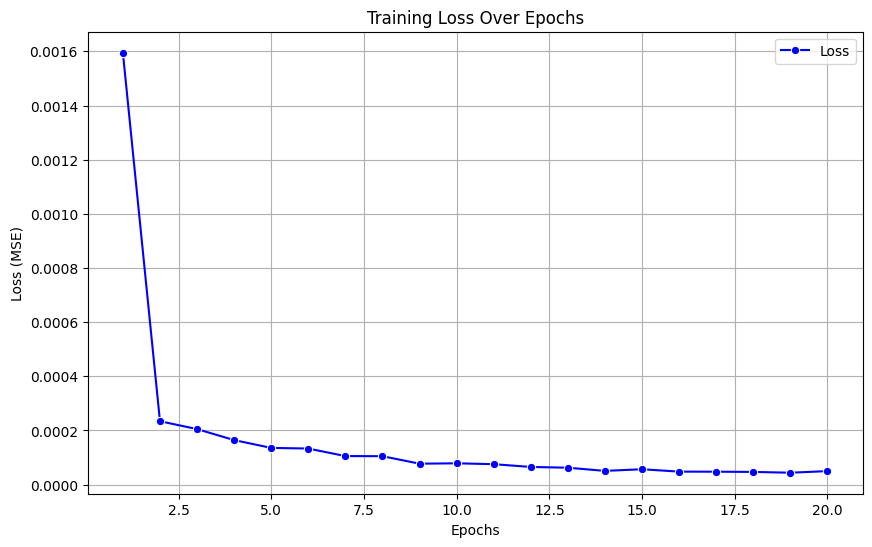

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

In [12]:
model = train_and_plot_loss(x_train, y_train)
model.summary()

**Validation**

In [13]:
# Prepare input data for validation
inputs_valid_df = stock_df[-len(valid_df) - train_window:].values.reshape(-1, 1)  # Extract and reshape the validation input data
inputs_valid_df = scaler.transform(inputs_valid_df)  # Scale the input data

# Generate X_test using list comprehension
X_test = np.array([inputs_valid_df[i-train_window:i, 0] for i in range(train_window, inputs_valid_df.shape[0])])

# Reshape X_test for model input
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

X_test.shape

(1256, 30, 1)

In [14]:
predicted_valid_price = model.predict(X_test)
predicted_valid_price= scaler.inverse_transform(predicted_valid_price)
rms=np.sqrt(np.mean(np.power((valid_df-predicted_valid_price),2)))
print('RMSE value on validation set:',rms)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
RMSE value on validation set: 4.987700053382554


In [15]:
valid_df['predicted_valid_price'] = predicted_valid_price

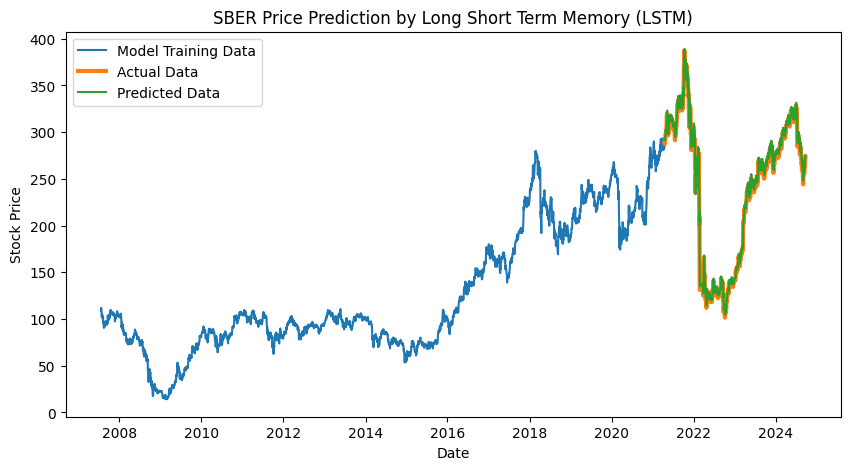

In [16]:
#Visualize the prediction
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(stock_df['Price'], label='Model Training Data')
plt.plot(valid_df['Price'], label='Actual Data', linewidth=3)
plt.plot(valid_df['predicted_valid_price'], label='Predicted Data')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title(f'{stock_symbol} Price Prediction by Long Short Term Memory (LSTM)')
plt.legend()

**Save educated model**

In [17]:
save_data = {'model': model}
with open('LSTM_stock_model.pkl', 'wb') as f:
    pickle.dump(save_data, f)

In [18]:
with open('LSTM_stock_model.pkl', 'rb') as f:
    load_data = pickle.load(f)
model = load_data['model']

**Predict X days ahead**

In [19]:
periods_to_predict = 30
train_window = 30

In [20]:
# fetching data for prediction

inputs_data = stock_df[-train_window:].values.reshape(-1, 1)
inputs_data = scaler.transform(inputs_data)
X_inputs_test = np.array([inputs_data])
X_inputs_test = np.reshape(X_inputs_test, (X_inputs_test.shape[0], X_inputs_test.shape[1], 1))
X_inputs_test.shape

(1, 30, 1)

In [21]:
# Function to set date index
def set_date_index(df, start_date):
    date_range = pd.date_range(start=start_date, periods=len(df), freq='D')
    df.index = date_range
    return df

# Function to add deviation bounds
def add_deviation_bounds(df, initial_spread=0.1, spread_growth_rate=0.08):
    rolling_mean = df['Price'].rolling(window=1, min_periods=1).mean()  # Calculate rolling mean
    std_dev = df['Price'].std()  # Calculate standard deviation for the entire dataset
    
    # Add columns for lower and upper bounds of the spread
    spread = initial_spread + spread_growth_rate * np.arange(len(df))
    df['lower_bound'] = rolling_mean - spread * std_dev
    df['upper_bound'] = rolling_mean + spread * std_dev
    return df

# Generate predictions and update input data
predicted_data = []
for _ in range(periods_to_predict):
    next_pred = model.predict(X_inputs_test)
    predicted_data.append(next_pred[0, 0])  # Store prediction
    next_pred_scaled = np.reshape(next_pred, (1, 1, 1))  # Reshape prediction
    X_inputs_test = np.append(X_inputs_test[:, 1:, :], next_pred_scaled, axis=1)  # Update the test set

# Convert predicted data and inverse scale
predicted_data = scaler.inverse_transform(np.array(predicted_data).reshape(-1, 1))

# Create DataFrame with predicted data
predicted_df = pd.DataFrame(predicted_data, columns=['Price'])

# Set date index and add deviation bounds
predicted_df = set_date_index(predicted_df, stock_df.index[-1]+timedelta(1))
predicted_df = add_deviation_bounds(predicted_df, initial_spread=0.1, spread_growth_rate=0.09)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

In [22]:
# Function for visualization using plotly
def plot_stock_prediction(stock_df, predicted_df, window=50, stock_symbol='Stock'):

    # Calculate the moving average
    rolling_mean = stock_df['Price'].rolling(window=window).mean()
    
    # Creating a model training schedule
    trace1 = go.Scatter(
        x=stock_df.index,
        y=stock_df['Price'],
        mode='lines',
        name='Actual Data',
        line=dict(color='blue')
    )
    
    # Creating a graph of predicted data
    trace2 = go.Scatter(
        x=predicted_df.index,
        y=predicted_df['Price'],
        mode='lines',
        name='Predicted Data',
        line=dict(color='green', width=1)
    )

    # Moving Average chart
    trace3 = go.Scatter(
        x=stock_df.index,
        y=rolling_mean,
        mode='lines',
        name=f'Moving Average ({window})',
        line=dict(color='red', width=1)
    )

    # Lower Bound Graph
    trace_lower_bound = go.Scatter(
        x=predicted_df.index,
        y=predicted_df['lower_bound'],
        mode='lines',
        name='Lower Bound',
        line=dict(color='gray', width=0.1),
        showlegend=False
    )

    # Top border plot with gray fill
    trace_upper_bound = go.Scatter(
        x=predicted_df.index,
        y=predicted_df['upper_bound'],
        mode='lines',
        name='Upper Bound',
        line=dict(color='gray', width=0.01),
        fill='tonexty',  # Fill the space between the top and bottom borders
        fillcolor='rgba(192, 192, 192, 0.7)',  # Gray color with transparency
        showlegend=False
    )

    # Axes and title
    layout = go.Layout(
        title={
            'text': f'{stock_symbol} Price Prediction',
            'font': dict(size=24, family="Arial", color="black", weight="bold")
        },
        xaxis=dict(title='Date'),
        yaxis=dict(
            title='Price',
            side='left',
            overlaying='y',
        ),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1)
    )
    
    # # Assembling the graph
    fig = go.Figure(data=[trace1, trace_lower_bound, trace_upper_bound, trace2], layout=layout)

    # Displaying the graph
    pio.show(fig)

num_last_preiods = 300
plot_stock_prediction(stock_df[-num_last_preiods:], predicted_df, window=50, stock_symbol=stock_symbol)


---

Доработки LSTM:
1. Поиск параметров модели с помощью: Grid Search, Random Search, Байесовской оптимизации, и кросс-валидации для предотвращения обучения
2. Использовать не одну, а несколько ценных бумаг в качестве исторических данных для обучения
3. Использовать не один признак(цену), а несколько (объём, цены high, low и т.д.) + corr matrix